In [1]:
import numpy as np, plottools as pl, constant as c, camb
from camb import model, initialpower
from matplotlib.pyplot import *

In [7]:
def prepare_cls(lmax=4000):
    #Set up a new set of parameters for CAMB
    pars = camb.CAMBparams()
    #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=1)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    pars.WantTensors = True
    results = camb.get_transfer_functions(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    # lensed Cls
    ls = np.arange(powers['lensed_scalar'].shape[0])
    fac = ls*(ls+1)/(2*np.pi)*c.Tcmb**2
    lcl = np.zeros((4,lmax+1))
    lcl[0,2:] = powers['lensed_scalar'][2:lmax+1,0]/fac[2:lmax+1]
    lcl[1,2:] = powers['lensed_scalar'][2:lmax+1,1]/fac[2:lmax+1]
    lcl[2,2:] = powers['lensed_scalar'][2:lmax+1,2]/fac[2:lmax+1]
    lcl[3,2:] = powers['lensed_scalar'][2:lmax+1,3]/fac[2:lmax+1]
    return lcl    

In [3]:
def noise(lcl,sig,theta,alpha):
    nl = lcl*0.
    nl[0,:] = .5*(sig*c.ac2rad/c.Tcmb)**2*np.exp(L*(L+1)*(theta*c.ac2rad)**2/8./np.log(2.))
    nl[1,:] = 2*nl[0,:]
    nl[2,:] = 2*nl[0,:]
    Lcl = lcl.copy()
    Lcl[2,:] *= alpha
    return Lcl + nl

In [4]:
def snr_eb(lcl,ocl,L,Lmin):
    SN = (2*L+1.)*(lcl[1,:]-lcl[2,:])**2/( ocl[1,:]*ocl[2,:] )
    sn = np.pi/180. * 2. * np.sqrt( np.sum(SN[Lmin+1:]) )
    return sn

In [28]:
Lmin, Lmax  = 500, 3000       # maximum multipole of output normalization
L = np.linspace(0,Lmax,Lmax+1)
theta  = 4.
fsky   = 10./41000.
sigs   = np.array([6.,5.,4.,3.,2.,1.])
alphas = np.array([1.,.5,.3])
print(fsky)

0.00024390243902439024


In [12]:
lcl = prepare_cls(lmax=Lmax)

In [29]:
snr = np.zeros((len(alphas),len(sigs)))
for j, alpha in enumerate(alphas):
    for i, sig in enumerate(sigs):
        ocl = noise(lcl,sig,theta,alpha)
        snr[j,i] = snr_eb(lcl,ocl,L,Lmin)

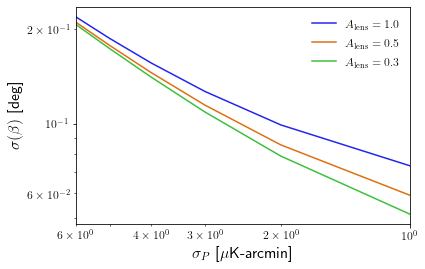

In [31]:
pl.plot_1dstyle(usetex=True,xmin=sigs[0],xmax=sigs[-1],xlog=True,ylog=True,xlab='$\sigma_P$ [$\mu$K-arcmin]',ylab=r'$\sigma(\beta)$ [deg]')
for j, alpha in enumerate(alphas):
    plot(sigs,1./snr[j,:]/np.sqrt(fsky),ls='-',label=r'$A_{\rm lens}='+str(alpha)+'$')
legend()
#savefig('fig_const_comp.pdf')